# Optimizing User Engagement: A/B Testing with Digial Media Data using Data-Driven Decisions

**Vision**:
A/B Testing has been around over a century now. It has been a prime way a lot of big companies make their decisions. It is a method to detect how a specific version of something compares to the other version, when subjected to a sort of limited testing. To read more, [here](https://hbr.org/2017/06/a-refresher-on-ab-testing) is a link for an article by Harvard Business Review. The inspiration of the project was to learn given a company data, how can statistical testing (A/B Testing, Hypothesis Testing) can be used to drive decisions. 

**Objectives**:
With a data of 20,000 customers, analyze if the engagement of users within the treatment group (ad group) was significent enough to commit to a decision of replacing the psa with the advertising efforts.

**Acknowledgements**:
The dataset for this project was taken from Kaggle, which can be found [here](https://www.kaggle.com/datasets/farhadzeynalli/online-advertising-effectiveness-study-ab-testing?resource=download). Thank you to Farhad Zeynalli, for the curation of the data set.

Exploring what other people have done with the data, I found the [notebook](https://www.kaggle.com/code/freshoats/ab-test-and-analysis) by *Justin R. Papreck* particularly insightful. Thank you Justin for your insightful work.

### A/B Testing Variants
- Control Group (A): The group exposed to the PSA (public service announcement).
- Treatment Group (B): The group exposed to the ad.

Methodology:
- Splitting the audience: Randomly dividing participants into two groups—control and treatment.
- Measuring performance: Tracking the conversion rate (CR) for each group.
- Comparing results: Analyzing the performance of the treatment against the control group to determine if the observed differences are statistically    significant.

 *In this project, A/B testing was applied to assess the effectiveness of the ad versus the PSA, specifically measuring the conversion rate (CR) for both groups*

### Libraries and data import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, mannwhitneyu
from statsmodels.stats.power import TTestIndPower
from scipy.stats import ttest_ind
from scipy.stats import norm
import statsmodels.api as sm

In [36]:
sns.set(style="whitegrid")

In [37]:
np.random.seed(42)
#loading the data
data = pd.read_csv("online_ad_AB.csv")

In [38]:
data.head()

,customerID,test group,made_purchase,days_with_most_add,peak ad hours,ad_count
0,1,ad,False,24,20,5
1,2,psa,False,21,16,9
2,3,psa,False,1,18,8
3,4,ad,False,20,23,7
4,5,ad,False,3,13,5


Here is a brief description of the dataset:
A large company with a substantial user base plans to increase sales through advertisement on its website. However, they are still undecided about whether the ads increase sales or not. In order to determine whether this is the case, 20000 customers were subjected to A/B testing for 31 days.

Columns:

- customerID: unique identifier for the customer
- test group: composed of 60% 'ad' and 40% 'psa' group.
- made_purchase: A Boolean value representing whether or not the user made a purchase after seeing an advertisement.
- days_with_most_add: A day of the month when the user saw the most ads.
- peak ad hours: An hour of the day when the user saw the most ads.
- ad_count: total number of ads seen by each user.


## Power Analysis
Power analysis helps determine the minimum sample size required to detect a significant effect. Key parameters:
1. **Effect Size (Cohen's d):** A standardized measure of effect magnitude.
   - Small: 0.2, Medium: 0.5, Large: 0.8
2. **Significance Level (α):** Probability of a false positive (default: 0.05).
3. **Power (1 - β):** Probability of detecting a true effect (default: 0.8).

### Interpretation of Results:
- **Sample size too small:** Risk of Type II errors (false negatives).
- **Sample size sufficient:** Reliable statistical results with reduced error risk.


In [39]:
effect_size = 0.5  # Medium effect size
alpha = 0.05  # Significance level
power = 0.8  # Desired power
analysis = TTestIndPower()
required_sample_size = analysis.solve_power(effect_size, alpha=alpha, power=power, alternative="two-sided")
print(f"Required Sample Size: {required_sample_size:.2f} per group")

Required Sample Size: 63.77 per group


In [114]:
print("Count for the Ad or Treatment group:")
print(data[data['Group']== 'ad'].count()[0])
print("Count for the psa or control group:")
print(data[data['Group']== 'psa'].count()[0])

Count for the Ad or Treatment group:
12053
Count for the psa or control group:
7947


Looking at this number it is clear that we have much more samples to make the results statistically significent, around 12k for the treatment group and 8k for psa group.

In [40]:
data.columns

Index(['customerID', 'test group', 'made_purchase', 'days_with_most_add',
       'peak ad hours', 'ad_count'],
      dtype='object')

Looking at the columns, I would just go ahead and rename the columns for clarity.

In [41]:
data = data.rename(columns={'customerID':'Customer_ID','test group':'Group','made_purchase':'Made_Purchase','days_with_most_ad':'Days_with_mose_ad','peak ad hours':'Peak_Ad_Hours'})

In [42]:
data.columns

Index(['Customer_ID', 'Group', 'Made_Purchase', 'days_with_most_add',
       'Peak_Ad_Hours', 'ad_count'],
      dtype='object')

Group Counts:
Group
ad     12053
psa     7947
Name: count, dtype: int64
The '%' of psa group:
60.265
The '%' of ad group:
39.735


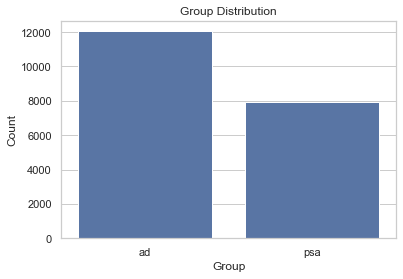

In [135]:
group_counts = data['Group'].value_counts()
print("Group Counts:")
print(group_counts)
print("The '%' of psa group:")
sum_of_value_counts = data['Group'].value_counts()[0]+data['Group'].value_counts()[1]
print(data['Group'].value_counts()[0]*100/sum_of_value_counts)
print("The '%' of ad group:")
print(data['Group'].value_counts()[1]*100/sum_of_value_counts)

# Plot the counts
sns.countplot(x='Group', data=data, order=group_counts.index)
plt.title("Group Distribution")
plt.xlabel("Group")
plt.ylabel("Count")
plt.show()

As mentioned in the intial data card description, the graph and the stats go on to show the 60% to 40% ratio of the ad and psa group. 

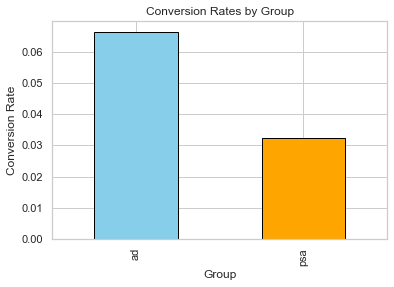

In [45]:
# Conversion Rates by Group
conversion_rates = data.groupby("Group")["Made_Purchase"].mean()
conversion_rates.plot(kind='bar',color=['skyblue','orange'], edgecolor = 'black')
plt.title("Conversion Rates by Group")
plt.ylabel("Conversion Rate")
plt.show()

Here the conversion rate for the ad group is greater than that of the psa group. This show favorability to the ad group to the psa group. 
Let us use hypothesis testing to validate the significence of the conversion rate.

#### Hypothesis Testing : To check the significence of the conversion rate

**Null Hypothesis :** The conversion rates of the ad group and control group are equal.
**Alternative Hypothesis:** The conversion rates of the ad group is greater than the control group.

Our data does hold the three assumptions of hypothesis testing:
1. The observations are independant.
2. The data should be categorical, which it is as it is a boolean variable.
3. The sample size is enough for both the groups

In [136]:
ad_conversions = data[data['Group'] == 'ad']['Made_Purchase']
control_conversions = data[data['Group'] == 'psa']['Made_Purchase']

# Proportion z-test
ad_count = ad_conversions.sum()
control_count = control_conversions.sum()
ad_total = len(ad_conversions)
control_total = len(control_conversions)

# Calculate proportions
p_ad = ad_count / ad_total
p_control = control_count / control_total

# Pooled proportion
p_pooled = (ad_count + control_count) / (ad_total + control_total)

# Standard error
se = np.sqrt(p_pooled * (1 - p_pooled) * (1 / ad_total + 1 / control_total))

# Z-statistic
z_stat = (p_ad - p_control) / se

# P-value for one-tailed test (greater)
p_val = 1 - norm.cdf(z_stat)

print(f"Z-statistic: {z_stat}, P-value: {p_val:.28f}")

Z-statistic: 10.590153051109288, P-value: 0.0000000000000000000000000000


In [57]:
t_stat, p_val_ttest = ttest_ind(ad_conversions, control_conversions, alternative='greater')
print(f"t-statistic: {t_stat}, p-value: {p_val_ttest}")

t-statistic: 10.619439999531432, p-value: 1.4216908642207938e-26


Initially the proportions_ztest module was not working from scipy for some reason. At a level of more than a thousand samples, the results of both the Z-test and T-test are essentially the same. So I performed a t-test as well. which gave a very small p-value, indicating the favorability of the conversion rate is indeed statistically significent.

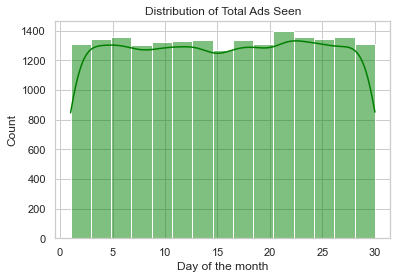

In [60]:
# Total Ads Seen Distribution
sns.histplot(data["days_with_most_add"], kde=True, bins=15, color="green")
plt.title("Distribution of Total Ads Seen")
plt.xlabel("Day of the month")
plt.show()

This distribution represents the count of the users who saw the most advertisements throughout the month.  This is good for us as we do not have to worry about there being more entries for a specific day and hence avoiding a lot of variations.

Now let us look at peak ad hours and observe by time. This would help us analyze the time when users are most active.


Text(0.5, 0, 'Time')

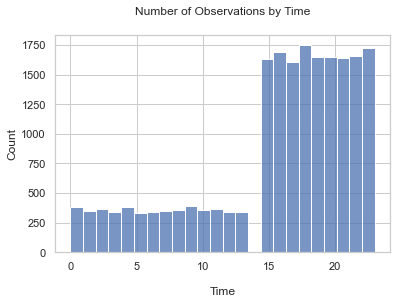

In [63]:
plt.figure(figsize=(6, 4))

sns.histplot(data=data['Peak_Ad_Hours'], bins=24)
plt.title('Number of Observations by Time', pad=20)
plt.xlabel('Time', labelpad=15)

There are two things that strike out the most here:
1. There is no entry for the hour no. 14, meaning either this data was not recorded or it was not collected.
2. These almost seem like two different distributions, clearly the second part which is 3'o clock onwards is significently higher in count.

The first impression this data gives is that it might be optmial to show ads after 3'o clock. However every visualization needs more to build the context around it - we need to analyze how much of the actual advertisements after 3 actually lead to purchase - this can be attriubted to various factors, most of them uncontrollable. Maybe nobody wants to order anything in the later evening, since it is a time when most people relax? That is onviously a naive hunch to say that there is more to the story.

Now looking at the number of impressions of user - referring to the number of ads seen by each user.

Text(0.5, 0, 'Number of Impressions')

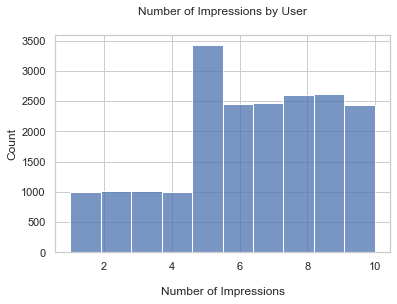

In [64]:
plt.figure(figsize=(6, 4))

sns.histplot(data=data['ad_count'], bins=10)
plt.title('Number of Impressions by User', pad=20)
plt.xlabel('Number of Impressions', labelpad=15)


One of the key observations to note down here is that on average a user watches 5 advertisement. This might be a critical information which can later be used to analyze the ideal number of advertisement for a campaign to be successful.

As a great idea by Justin, these two distributions look relatively similar, so let us analyze the variation between the number of impressions and the number of observations by time.

Text(0, 0.5, 'Number of Impressions')

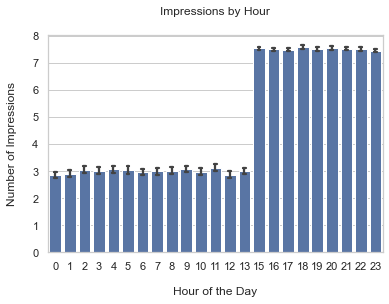

In [65]:
plt.figure(figsize=(6, 4))

sns.barplot(data=data, x = 'Peak_Ad_Hours', y = 'ad_count', estimator=np.mean, errorbar=('ci',90), capsize=0.2)
plt.title('Impressions by Hour', pad=20)
plt.xlabel('Hour of the Day', labelpad=15)
plt.ylabel('Number of Impressions', labelpad=15)

Looking at this distribution it is likely that this was a part of design of the experiement to approximately take in a certain number of values for each hour.

In [137]:
# Determing the conversion rate difference
control_group = data[data['Group'] == 'psa']['Made_Purchase'] 
treatment_group = data[data['Group'] == 'ad']['Made_Purchase']

control_users = control_group.count()
treatment_users = treatment_group.count()

conversions = [control_group.sum(), treatment_group.sum()]
nobs = [control_users, treatment_users]  # Total users in each group

# Conversion rates
cr_control = conversions[0] / nobs[0]
cr_treatment = conversions[1] / nobs[1]

# Lift calculation
lift = (cr_treatment - cr_control) / cr_control * 100

# Confidence intervals for conversion rates
z = 1.96  # Z-value for 95% confidence
margin_control = z * np.sqrt((cr_control * (1 - cr_control)) / nobs[0])
margin_treatment = z * np.sqrt((cr_treatment * (1 - cr_treatment)) / nobs[1])

ci_control = (cr_control - margin_control, cr_control + margin_control)
ci_treatment = (cr_treatment - margin_treatment, cr_treatment + margin_treatment)

# Proportions Z-Test
z_stat, p_ztest = sm.stats.proportions_ztest(conversions, nobs)

# Effect Size (Cohen's h)
def cohen_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

effect_size = cohen_h(cr_treatment, cr_control)

# Display results
print(f"Control CR: {cr_control:.2%} (95% CI: {ci_control[0]:.2%} - {ci_control[1]:.2%})")
print(f"Treatment CR: {cr_treatment:.2%} (95% CI: {ci_treatment[0]:.2%} - {ci_treatment[1]:.2%})")
print(f"Lift: {lift:.2f}%")
print(f"Proportions Z-Test p-value: {p_ztest:.28f}")
print(f"Effect Size (Cohen's h): {effect_size:.2f}")

# Interpretation
if p_ztest < 0.05:
    print("The difference in conversion rates is statistically significant.")
else:
    print("No significant difference in conversion rates.")


Control CR: 3.23% (95% CI: 2.84% - 3.62%)
Treatment CR: 6.66% (95% CI: 6.22% - 7.11%)
Lift: 106.01%
Proportions Z-Test p-value: 0.0000000000000000000000000331
Effect Size (Cohen's h): 0.16
The difference in conversion rates is statistically significant.


The above calculations give us a solid range for the CR. Here are the key observations:
- The CR of Control Group is lower than that of Treatment group, additionally the narrow range of the CI adds to the precision of these results.
- The lift of 106.01% shows a significent increase in the rate.
- Note here that the p-value is very close to zero, adding to the significence of the results.
- The effect size however of 0.16 suggests that even though there is an improvement, it is modest in terms of the driving force of the decisions. A small effect suggests that the business should make a decision based on the business resource constraints.

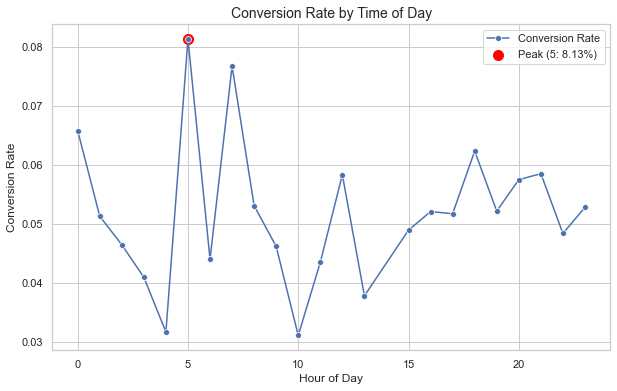

In [ ]:
# Group by the time of day and calculate conversion rates
time_conversion = data.groupby('Peak_Ad_Hours')['Made_Purchase'].agg(['sum', 'count'])
time_conversion['CR'] = time_conversion['sum'] / time_conversion['count']

# Identify the peaks (maximum conversion rate)
peak_hour = time_conversion['CR'].idxmax()
peak_value = time_conversion['CR'].max()

# Plot the conversion rates by time of day
plt.figure(figsize=(10, 6))
sns.lineplot(x=time_conversion.index, y=time_conversion['CR'], marker='o', label='Conversion Rate')

# Highlight the peak value
plt.scatter(peak_hour, peak_value, color='red', s=100, label=f'Peak ({peak_hour}: {peak_value:.2%})')

# Add title and labels
plt.title("Conversion Rate by Time of Day", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Conversion Rate", fontsize=12)
plt.grid(True)

# Add legend
plt.legend()

# Show the plot
plt.show()


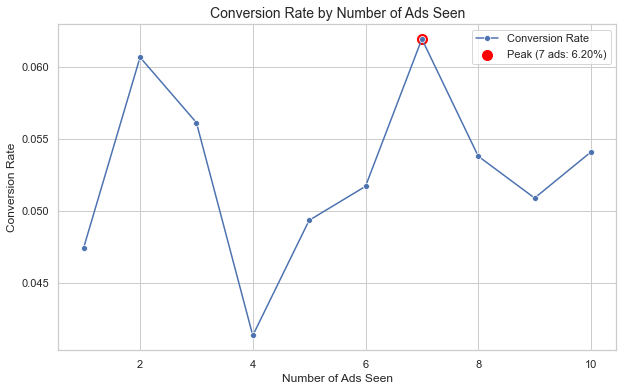

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data by the number of ads seen and calculate conversion rates
ad_exposure = data.groupby('ad_count')['Made_Purchase'].agg(['sum', 'count'])
ad_exposure['CR'] = ad_exposure['sum'] / ad_exposure['count']

# Identify the peak (maximum conversion rate)
peak_ads = ad_exposure['CR'].idxmax()
peak_value = ad_exposure['CR'].max()

# Plot conversion rates by the number of ads seen
plt.figure(figsize=(10, 6))
sns.lineplot(x=ad_exposure.index, y=ad_exposure['CR'], marker='o', label='Conversion Rate')

# Highlight the peak value
plt.scatter(peak_ads, peak_value, color='red', s=100, label=f'Peak ({peak_ads} ads: {peak_value:.2%})')

# Add title and labels
plt.title("Conversion Rate by Number of Ads Seen", fontsize=14)
plt.xlabel("Number of Ads Seen", fontsize=12)
plt.ylabel("Conversion Rate", fontsize=12)
plt.grid(True)

# Add legend
plt.legend()

# Show the plot
plt.show()


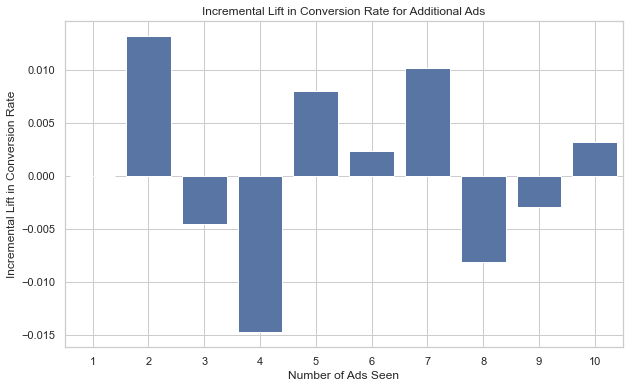

In [104]:
# Calculate the incremental lift between successive ad exposure levels
ad_exposure['Lift'] = ad_exposure['CR'].diff().fillna(0)

# Plot the incremental lift in conversion rate for additional ads
plt.figure(figsize=(10, 6))
sns.barplot(x=ad_exposure.index, y=ad_exposure['Lift'])
plt.title("Incremental Lift in Conversion Rate for Additional Ads")
plt.xlabel("Number of Ads Seen")
plt.ylabel("Incremental Lift in Conversion Rate")
plt.grid(True)
plt.show()


Analysis of Results:
Based on the results, conversion rate is highest at 5:00 AM which is a quite surprising time of the day. Plus, the change is highest from 4:00 AM to 5:00 which then decreases at 6, again increasing at 7. This behaviour suggests that starting from 5:00 to 7:00 AM might be a good time to show the advertisements.

For the number of ads seen we have two graphs, one analyzing the conversion rate and the other analyzing the change in the conversion rate. Analyzing the first graph, the peaks are at 2 and 7. Adding to the analysis with the results of the second graph, we can see the highest change in positive direction is observed at 2, and then an increamental change from 5 to 7. What does this mean - the ideal number for showing the ads could either be 2 or from 5 to 7. Having two options, the company can stratergically decide how many ads to show either 2 or a number between 5 to 7, based on the budget and constraints.

# Final Results and Summary
1. The implementation of the ad would result in an improvement of the CR, however the decision might be a result of the business resource contraints, for the improvement is just modest. *Company could add more dimensions to the data to further info if they are willing to invest in the experiment design*
2. The optimal number of ads is in the range 5-7 with the most optimal number being 5, as a result of increase in conversion rate, as well as the highest number of impressions being 5 throughout the data.
3. The optimal time for the users has two possibilities with the first possibility being of higher value than the later, the first one is 5:00 AM - 7:00 AM & the second one is 5 PM to 9 PM. 

One of the other observations is, the business could show 2 (or the minimum number of ads) in early morning - as there is a high fluctuation in the CR. The advertisements which comparatively cost less and allow for more repetition could be telecasted in the evening timeframe, as the viewer engagement is more consistent here.

_Thank you for reading through the notebook, feel free to check out my portfolio at yashtobre.framer.website ; and reach out to me on [LinkedIn](https://www.linkedin.com/in/yashtobre/)_